In [2]:
%load_ext autoreload
%autoreload 2

import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import poisson, nbinom, lognorm

from cytominer_eval import evaluate_metrics
from cytominer_eval.transform import metric_melt, copairs_similarity
from cytominer_eval.utils.transform_utils import check_replicate_groups
from cytominer_eval.utils.operation_utils import assign_replicates, set_pair_ids

from cytominer_eval.operations import (
    replicate_reproducibility,
    precision_recall,
    grit,
    mp_value,
    enrichment,
    hitk,
)

from copairs.map import create_matcher, flatten_str_list, run_pipeline

from scripts.generate_utils import (
    generate_distribution_params,
    generate_distribution_params_differ,
    generate_features,
    aggregate_metrics_results,
    calculate_accuracy,
)

In [3]:
plate_col = "Metadata_Plate"
plate_map_col = "Metadata_Plate_Map"
well_col = "Metadata_Well"
pert_col = "Metadata_Perturbation"
negcon_pert_value = "negative_control"

SEED = 42

In [4]:
# # Example usage
# rng = np.random.default_rng(SEED)
# n_plates, n_wells, n_perts, n_controls, n_feats, n_plate_maps = 3, 5, 4, 1, 100, 2
# feature_proportions = {'gaussian': 1.0, 'lognormal': 0.0, 'poisson': 0.0, 'nbinom': 0.0}
# control_params = { "gaussian": (0, 1), "lognormal": (0, 1), "poisson": 3, "nbinom": (1, 0.5) }

# pert_params = generate_distribution_params(n_perts, rng)

# dframe, feats = generate_features(n_plates, n_wells, n_perts, n_controls, n_feats, n_plate_maps, feature_proportions, control_params, pert_params, rng)

# print(dframe)

In [14]:
rng = np.random.default_rng(SEED)

n_plates = 2
# n_wells = 108  -> # set to n_per_plate + n_controls
n_perts = 100  # constant
n_controls = 9
n_feats = 100
n_plate_maps = 1  # constant
n_perts_differ = 0

feature_proportions = {"gaussian": 1.0, "lognormal": 0.0, "poisson": 0.0, "nbinom": 0.0}
features_differ = {"gaussian": 64, "lognormal": 0, "poisson": 0, "nbinom": 0}

control_params = {
    "gaussian": (0, 1),
    "lognormal": (0, 1),
    "poisson": 3,
    "nbinom": (1, 0.5),
}
differ_params = {
    "gaussian": (1, 1),
    "lognormal": (0, 1),
    "poisson": 3,
    "nbinom": (1, 0.5),
}

replicate_groups = {
    "pos_sameby": {"all": [f"{pert_col} != '{negcon_pert_value}'"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Metadata_Perturbation_Type"], "any": []},
}

metrics_config = {
    "replicate_reproducibility": {
        "return_median_correlations": True,
        "quantile_over_null": 0.95,
        "replicate_groups": [f"{pert_col}"],
    },
    # "precision_recall": {"k": 10, "groupby_columns": [f"{pert_col}"]},
    # "enrichment": {"percentile": 0.99},
    # "hitk": {"groupby_columns": [f"{pert_col}"], "percent_list": [2, 5, 10]},
    "mp_value": {
        "control_perts": [f"{negcon_pert_value}"],
        "replicate_id": f"{pert_col}",
        "rescale_pca": True,
        "nb_permutations": 1000,
    },
    # "grit": {
    #     "control_perts": ["DMSO"],
    #     "profile_col": "Metadata_broad_sample",
    #     "replicate_group_col": "Metadata_mg_per_ml",
    #     "replicate_summary_method": "mean"
    # }
    "mean_ap": {
        "null_size": 1000,
        "groupby_columns": [f"{pert_col}"],
    },
}

In [15]:
pert_params, differ_perts = generate_distribution_params_differ(
    n_perts, n_perts_differ, control_params, differ_params, rng
)

dframe, feats = generate_features(
    n_plates,
    n_perts + n_controls,
    n_perts,
    n_controls,
    n_feats,
    n_plate_maps,
    feature_proportions,
    control_params,
    pert_params,
    rng,
    features_differ=features_differ,
    differ_params=differ_params,
    resample_perts=False,
)

metrics_results = evaluate_metrics(
    profiles=pd.concat([dframe, feats], axis=1),
    features=feats.columns,
    meta_features=dframe.columns,
    replicate_groups=replicate_groups,
    metrics_config=metrics_config,
    use_copairs=True,
)

acc = calculate_accuracy(metrics_results)


Calculating distances.
Pos pairs size: 100, Neg pairs size: 3600


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: replicate_reproducibility

Calculating metric: mean_ap


/Users/akalinin/Projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/2 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 100, Neg pairs size: 3600

Calculating metric: mp_value


Calculating mp-values:   0%|          | 0/100 [00:00<?, ?it/s]

IOStream.flush timed out


Processing groups:   0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
merged_metrics = aggregate_metrics_results(metrics_results, pert_col)
merged_metrics

,index,Metadata_Perturbation,similarity_metric,mean_ap,p_value,n_pos_pairs,n_total_pairs,clique_id,mp_value,-log10(p_value),-log10(mp_value),percent_replicating
0,0,c0,0.245894,1.0,0.054,1.0,19.0,1,0.031,1.267606,1.508638,0.0
1,1,c1,0.312643,1.0,0.054,1.0,19.0,46,0.029,1.267606,1.537602,0.0
2,2,c10,0.450652,1.0,0.054,1.0,19.0,2,0.079,1.267606,1.102373,0.0
3,3,c11,0.331626,1.0,0.054,1.0,19.0,89,0.003,1.267606,2.522879,0.0
4,4,c12,0.479979,1.0,0.054,1.0,19.0,0,0.038,1.267606,1.420216,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,c95,0.369688,1.0,0.054,1.0,19.0,10,0.040,1.267606,1.397940,0.0
96,96,c96,0.339383,1.0,0.054,1.0,19.0,50,0.026,1.267606,1.585027,0.0
97,97,c97,0.504686,1.0,0.054,1.0,19.0,29,0.064,1.267606,1.193820,0.0
98,98,c98,0.370541,1.0,0.054,1.0,19.0,76,0.058,1.267606,1.236572,0.0


In [17]:
acc

{'replicate_reproducibility': 0.0,
 'mp_value': 0.71,
 'mean_ap': 0.98,
 'mean_ap_p_value': 0.0}

### Run gaussian sweeps over params

In [8]:
feature_proportions_config = [
    # {"gaussian": 0.97, "lognormal": 0.01, "poisson": 0.01, "nbinom": 0.01},
    {"gaussian": 0.4, "lognormal": 0.4, "poisson": 0.1, "nbinom": 0.1},
    {"gaussian": 0.3, "lognormal": 0.3, "poisson": 0.2, "nbinom": 0.2},
]
print(feature_proportions_config)

[{'gaussian': 0.4, 'lognormal': 0.4, 'poisson': 0.1, 'nbinom': 0.1}, {'gaussian': 0.3, 'lognormal': 0.3, 'poisson': 0.2, 'nbinom': 0.2}]


In [9]:
# plate_nums = range(2, 4)
# control_nums = [4, 8, 16, 24]

# differ_params_configs = [{"gaussian": (i, 1), "lognormal": (i, 1), "poisson": i+1, "nbinom": (1, 0.5)} for i in range(1, 4)]
# print(differ_params_configs)

# features_differ_configs = [{"gaussian": 2**i, "lognormal": 0, "poisson": 0, "nbinom": 0} for i in range(7)]
# print(features_differ_configs)

features_differ = {"gaussian": 8, "lognormal": 8, "poisson": 8, "nbinom": 8}
differ_params = {"gaussian": (1, 1), "lognormal": (1, 1), "poisson": 2, "nbinom": (3, 0.2)}

In [10]:
non_gaussian_accuracy_results = []

pert_params, differ_perts = generate_distribution_params_differ(
    n_perts, n_perts_differ, control_params, differ_params, rng
)

for feature_proportions in feature_proportions_config:
    print(f"\nProcessing features_differ: {feature_proportions}")

    dframe, feats = generate_features(
        n_plates,
        n_perts + n_controls,
        n_perts,
        n_controls,
        n_feats,
        n_plate_maps,
        feature_proportions,
        control_params,
        pert_params,
        rng,
        features_differ=features_differ,
        differ_params=differ_params,
        resample_perts=False,
    )

    metrics_results = evaluate_metrics(
        profiles=pd.concat([dframe, feats], axis=1),
        features=feats.columns,
        meta_features=dframe.columns,
        replicate_groups=replicate_groups,
        metrics_config=metrics_config,
        use_copairs=True,
    )

    acc = calculate_accuracy(metrics_results)
    acc.update(
        {
            "n_plates": n_plates,
            "n_controls": n_controls,
            "feature_proportions": feature_proportions,
            "features_differ": features_differ,
            "differ_params": differ_params,
        }
    )
    non_gaussian_accuracy_results.append(acc)

# with open("non_gaussian_accuracy_results.pkl", "wb") as f:
#     pickle.dump(non_gaussian_accuracy_results, f)


Processing features_differ: {'gaussian': 0.4, 'lognormal': 0.4, 'poisson': 0.1, 'nbinom': 0.1}

Calculating distances.
Pos pairs size: 100, Neg pairs size: 3200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: replicate_reproducibility

Calculating metric: mean_ap


/Users/akalinin/Projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/2 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 100, Neg pairs size: 3200

Calculating metric: mp_value


Calculating mp-values:   0%|          | 0/100 [00:00<?, ?it/s]

IOStream.flush timed out


Processing groups:   0%|          | 0/100 [00:02<?, ?it/s]


Processing features_differ: {'gaussian': 0.3, 'lognormal': 0.3, 'poisson': 0.2, 'nbinom': 0.2}

Calculating distances.
Pos pairs size: 100, Neg pairs size: 3200


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Calculating metric: replicate_reproducibility

Calculating metric: mean_ap


/Users/akalinin/Projects/copairs/src/copairs/compute.py:105: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/2 [00:00<?, ?it/s]


Calculating distances.
Pos pairs size: 100, Neg pairs size: 3200

Calculating metric: mp_value


Calculating mp-values:   0%|          | 0/100 [00:00<?, ?it/s]

Processing groups:   0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
non_gaussian_accuracy_results

[{'replicate_reproducibility': 0.0,
  'mp_value': 0.96,
  'mean_ap': 0.91,
  'mean_ap_p_value': 1.0,
  'n_plates': 2,
  'n_controls': 8,
  'feature_proportions': {'gaussian': 0.4,
   'lognormal': 0.4,
   'poisson': 0.1,
   'nbinom': 0.1},
  'features_differ': {'gaussian': 8,
   'lognormal': 8,
   'poisson': 8,
   'nbinom': 8},
  'differ_params': {'gaussian': (1, 1),
   'lognormal': (1, 1),
   'poisson': 2,
   'nbinom': (3, 0.2)}},
 {'replicate_reproducibility': 0.0,
  'mp_value': 1.0,
  'mean_ap': 0.83,
  'mean_ap_p_value': 0.91,
  'n_plates': 2,
  'n_controls': 8,
  'feature_proportions': {'gaussian': 0.3,
   'lognormal': 0.3,
   'poisson': 0.2,
   'nbinom': 0.2},
  'features_differ': {'gaussian': 8,
   'lognormal': 8,
   'poisson': 8,
   'nbinom': 8},
  'differ_params': {'gaussian': (1, 1),
   'lognormal': (1, 1),
   'poisson': 2,
   'nbinom': (3, 0.2)}}]

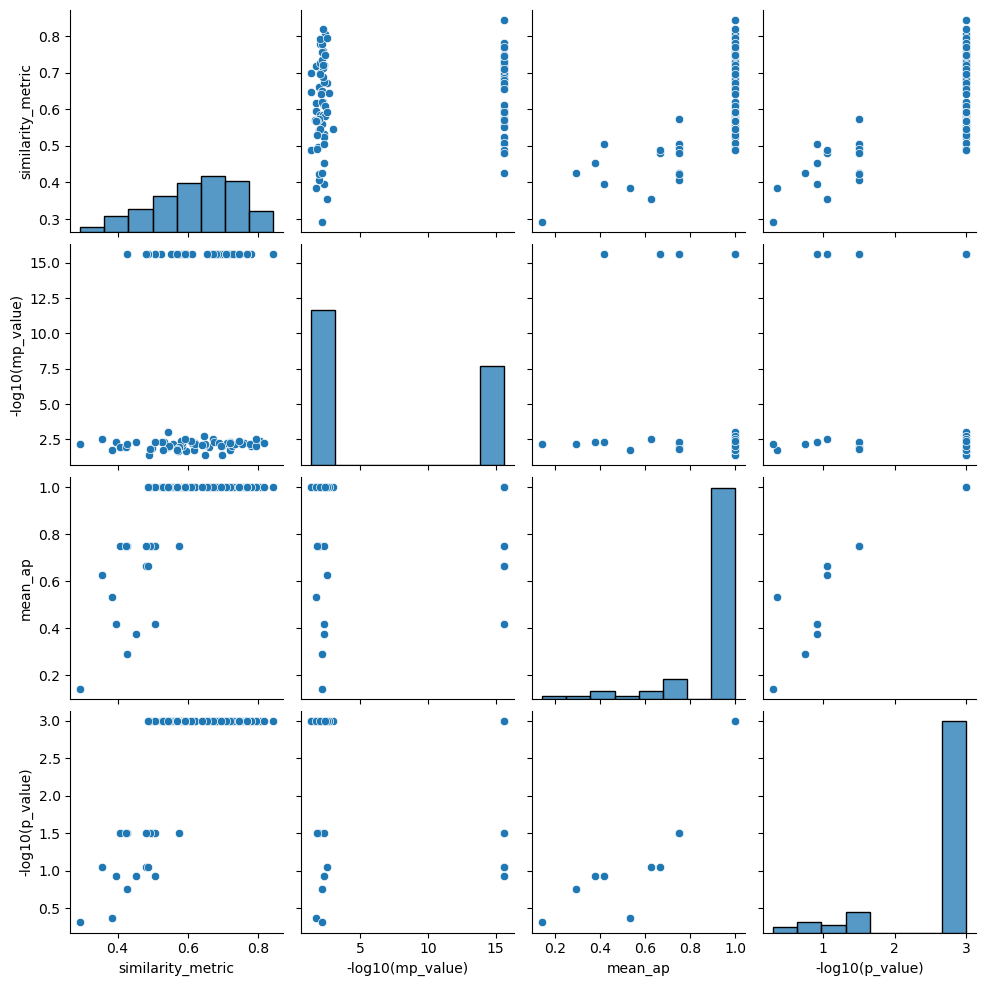

In [12]:
merged_metrics = aggregate_metrics_results(metrics_results, pert_col)

sns.pairplot(
    merged_metrics[
        [
            "similarity_metric",
            # "precision",
            # "recall",
            "-log10(mp_value)",
            "mean_ap",
            "-log10(p_value)",
        ]
    ]
)

In [13]:
feats[dframe["Metadata_Perturbation_Type"] == "treatment"].mean()

0     0.962191
1     0.985799
2     0.981398
3     0.992798
4     0.890185
        ...   
95    0.955000
96    0.935000
97    0.945000
98    1.180000
99    0.965000
Length: 100, dtype: float64

In [14]:
feats[dframe["Metadata_Perturbation_Type"] == "negative_control"].mean()

0     0.280146
1    -0.272737
2    -0.498241
3     0.136198
4    -0.225594
        ...   
95    1.125000
96    0.625000
97    0.937500
98    1.250000
99    1.375000
Length: 100, dtype: float64